# In this notebook the code is developed to solve the VeRoLog solver challenge to optimality. Pulp is used to create and execute the created MILP. We use the example instance of the VeRoLog challegence since it is rather small. The index of some variables have been moved by 1 since python starts indexing at 0. The formulas in this notebook are written with LaTeX.

## Imports

In [1]:
import logging
import math as math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pulp as plp
import time

In [2]:
import tempfile

print( tempfile.gettempdir())

C:\Users\31640\AppData\Local\Temp


In [3]:
logging.basicConfig(filename='VeRoLog MILP', level=logging.INFO,format='%(asctime)s:%(levelname)s:%(message)s')
solver_list = plp.listSolvers(onlyAvailable=True)
print(solver_list)
opt_model = plp.LpProblem(name="MIP_Model")
#plp.pulpTestAll()

['GLPK_CMD', 'PULP_CBC_CMD', 'PULP_CHOCO_CMD']


In [5]:
# import os as os
# pid = os.getpid()
# tmpLp = os.path.join(self.tmpDir, "%d-pulp.lp" % pid)
# tmpMps = os.path.join(self.tmpDir, "%d-pulp.mps" % pid)
# tmpSol = os.path.join(self.tmpDir, "%d-pulp.sol" % pid)
# if not os.path.exists(tmpSol):
#       raise PulpSolverError("Pulp: Error while executing "+self.path) 

In [6]:
solver = plp.getSolver('GLPK_CMD')

## Input parameters (the variable used in the formulas are commented next to the variable)

In [13]:
DAYS = 7                                                #T
technicians = [0,1,2,3,4]                                #H
trucks = [i for i in range(10)]                        #K (arbitrarily chosen)
machines = [0,1,2,3]                                         #M
customers = [i for i in range(7)]                    #C

customer_machine_types = [0,2,3,0,1,3,1]           #m_j
machine_size = [2,1,3,2]                                     #s_{m_j}
machine_penalty = [200,200,500,100]                              #pi_j
customer_order_size = [1,1,2,3,1,1,4]              #d_j
start_delivery_window = [0,2,1,4,0,0,2]              #a_j
end_delivery_window =  [6,5,2,6,3,5,4]              #b_j
technician_max_visits = [2,1,5,2,1]                      #r_h
technician_max_distance = [100,100,100,100,50]     #omega_h
technician_skill_set = [[0,1,1,1],[1,1,0,0],[0,0,1,0],[1,1,0,1],[1,1,1,1]]   #g_{h_m}
TRUCK_MAX_DISTANCE = 250                                #delta
TRUCK_CAPACITY = 6                                      #Q
LARGE_NUMBER = 1000                                      #L

TRUCK_DISTANCE_COST = 1                               #beta
TRUCK_DAY_COST = 100                                  #alpha
TRUCK_COST = 100000                                       #gamma
TECHNICIAN_DISTANCE_COST = 1                           #phi
TECHNICIAN_DAY_COST = 100000                              #lambda
TECHNICIAN_COST = 100                                     #mu

### Graph $G=(N,E)$

In [14]:
#nodes: dictionary of x and y coordinates
depot_node = {0:(10,50)}
customer_nodes = {1:(20, 10),2:(50, 5),3:(33, 7),4:(40, 40),5:(70,40),6:(1, 35),7:(1, 35)}   #\mathcal{C}
technician_nodes = {8:(50,5),9:(10,5),10:(10,5),11:(25,60),12:(10,50)}                       #\mathcal{H}
nodes = {**depot_node,**customer_nodes,**technician_nodes}                                   #N
number_of_nodes = len(nodes)
#edges and cost: every node is connected and the graph is directed
count = 1
edges = {}                                                                            #E
cost_edges = {}
for i in range(number_of_nodes):
    for j in range(number_of_nodes):
        if i!=j:
            edges[count] = (i,j)
            cost_edges[(i,j)] = math.ceil(math.sqrt((nodes[i][0] - nodes[j][0])**2+(nodes[i][1]-nodes[j][1])**2))
            count +=1

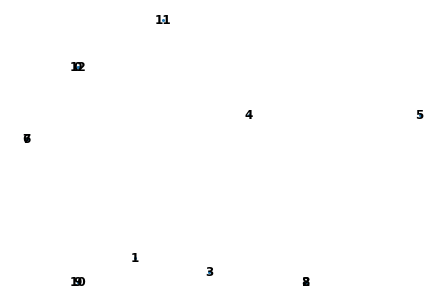

In [15]:
#create and plot the graph with networkx
G = nx.DiGraph()
G.add_nodes_from(nodes)
pos = {}
for node in G.nodes:
    pos[node] = nodes[node]
plt.figure(figsize=[6,4])
nx.draw(G,pos=pos, node_size=4, with_labels=True, font_weight='bold')
plt.show()

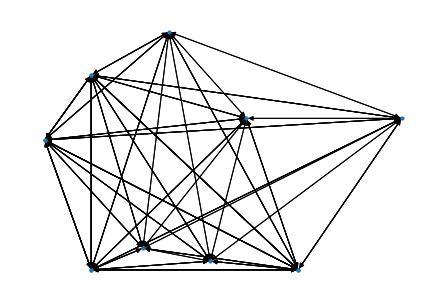

In [8]:
#with edges
G = nx.DiGraph()
for k,v in edges.items():
    G.add_edge(*v)
    
plt.figure(figsize=[6,4])
nx.draw(G,pos=pos, node_size=10)
plt.show()

## Data checks

In [9]:
if not len(technicians) == len(technician_nodes) == len(technician_max_visits) == len(technician_max_distance) == len(technician_skill_set):
    logging.error("ERROR: the technician data is not consistent")

if not len(customer_machine_types) == len(customer_order_size) == len(start_delivery_window) == len(end_delivery_window) ==len(customer_nodes) == len(customers):
    logging.error("ERROR: the customer data is not consistent")

if not len(machines) == len(machine_size) == len(machine_penalty):
    logging.error("ERROR: the machine data is not consistent")

for i in range(len(customer_nodes)):
    if start_delivery_window[i] < 0:
        logging.error("ERROR: the start of delivery window is smaller than 0")
    if start_delivery_window[i] >= end_delivery_window[i]:
        logging.error("ERROR: the start of delivery window is larger or equal than the end")
    if end_delivery_window[i] == DAYS-1:
        end_delivery_window[i] = end_delivery_window[i]-1 #one day is needed to install within horizon so might as well shift it
    if end_delivery_window[i] > DAYS-1:
        logging.error("ERROR: the end of delivery window is outside horizon")

for i in range(1,len(customer_nodes)+1):
    if 2*cost_edges[(0,i)] > TRUCK_MAX_DISTANCE:
        logging.error("ERROR: trucks can't reach customer {0}".format(i))

for i, machine_type in enumerate(customer_machine_types):
    if machine_size[machine_type] * customer_order_size[i] > TRUCK_CAPACITY:
        logging.error("ERROR: customer order is to large for truck capacity")         

tech_dist_check = [0 for i in range(len(customer_nodes))]
for i in range(len(customer_nodes)):
    MachineType = customer_machine_types[i]
    for tech in technicians:
        if technician_skill_set[tech][MachineType] == 1:
            if 2*cost_edges[(len(customer_nodes)+tech+1,i+1)] < technician_max_distance[tech]:
                tech_dist_check[i] = 1
if min(tech_dist_check) == 0:
    logging.error("ERROR: customer location is located too far from technicians")  

NameError: name 'technicians' is not defined

## Decision variables

### We have the following decision variables:
### $x_{tkij} \in \{0,1\} \text{: indicates if on day $t$, truck $k$, drives from node $i$ to $j$}$
### $y_{thij} \in \{0,1\} \text{: indicates if on day $t$, technician $h$, drives from node $i$ to $j$}$
### $u_k \in {\rm I\!R} \text{: indicates if truck $k$ is used in the problem}$
### $v_{tk} \in {\rm I\!R} \text{: indicates if on day $t$ truck $k$ is used}$
### $p_h \in {\rm I\!R} \text{: indicates if technician $h$ is used in the problem}$
### $q_{th} \in {\rm I\!R} \text{:  indicates if on day $t$ technician $h$ is used}$
### $z_{tkj} \in {\rm I\!R} \text{: cumulative load on day $t$, in truck $k$, when delivering to $j \in \mathcal{C}$}$
### $w_{th} \in \{0,1\} \text{: indicates if on day $t$ technician $h$ has worked for 5 days in a row}$

### where
### $ u_k \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} k \in K,                                                 $
### $ v_{tk} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K,                        $
### $ p_h \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} h \in H,                                                $
### $ q_{th} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H. $

In [17]:
# Continuous
u_k = {k: plp.LpVariable(cat=plp.LpContinuous, lowBound=0, 
                               name="u_{0}".format(k)) for k in trucks}
v_tk = {(t,k): plp.LpVariable(cat=plp.LpContinuous, lowBound=0,
                               name="v_{0}_{1}".format(t,k)) for t in range(DAYS) for k in trucks}
p_h = {h: plp.LpVariable(cat=plp.LpContinuous, lowBound=0, 
                               name="p_{0}".format(h)) for h in technicians}
q_th = {(t,h): plp.LpVariable(cat=plp.LpContinuous, lowBound=0, 
                               name="q_{0}_{1}".format(t,h)) for t in range(1,DAYS) for h in technicians}
z_tkj  = {(t,k,j): plp.LpVariable(cat=plp.LpContinuous, lowBound=0, 
                                  name="z_{0}_{1}_{2}".format(t,k,j)) for t in range(DAYS) for k in trucks for j in customer_nodes}

# Binary
x_tkij  = {(t,k,i,j): plp.LpVariable(cat=plp.LpBinary,
                                 name="x_{0}_{1}_{2}_{3}".format(t,k,i,j)) for t in range(DAYS) for k in trucks for i in nodes for j in nodes if j != i}
#installation can only start one day later than delivery
y_thij  = {(t,h,i,j): plp.LpVariable(cat=plp.LpBinary,
                                 name="y_{0}_{1}_{2}_{3}".format(t,h,i,j)) for t in range(1,DAYS) for h in technicians for i in nodes for j in nodes if j != i}
w_th = {(t,h): plp.LpVariable(cat=plp.LpBinary,
                                 name="w_{0}_{1}".format(t,h)) for t in range(DAYS) for h in technicians}


## Constraints

### Truck distance 
### $\sum\limits_{(i,j) \in E} x_{tkij} c_{ij} \leq \delta \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K$

In [11]:
truck_distance_cons = {(t,k) : opt_model.addConstraint(plp.LpConstraint(e=plp.lpSum(x_tkij[t,k,i,j] * cost_edges[i,j] for i,j in edges.values()),
                                             sense=plp.LpConstraintLE,
                                             rhs=TRUCK_MAX_DISTANCE, 
                                             name="truck_distance_{0}_{1}".format(t,k))) for t in range(DAYS) for k in trucks}

NameError: name 'DAYS' is not defined

### Technician distance
### $\sum\limits_{(i,j) \in E} y_{thij} c_{ij} \leq \omega_{h} \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H$

In [11]:
technician_distance_cons = {(t,h) : opt_model.addConstraint(plp.LpConstraint(e=plp.lpSum(y_thij[t,h,i,j] * cost_edges[i,j] for i,j in edges.values()),
                                             sense=plp.LpConstraintLE,
                                             rhs=technician_max_distance[h], 
                                             name="technician_distance_{0}_{1}".format(t,h))) for t in range(DAYS) for h in technicians}

KeyError: (0, 0, 0, 1)

### Technician visits
### $\sum\limits_{i \in N}\sum\limits_{j \in \mathcal{C}} y_{thij} \leq r_h \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i \neq j) $

In [ ]:
technician_visits_cons = {(t,h) : opt_model.addConstraint(plp.LpConstraint(e=plp.lpSum(y_thij[t,h,i,j] for i in nodes for j in customer_nodes if i !=j),
                                             sense=plp.LpConstraintLE,
                                             rhs=technician_max_visits[h], 
                                             name="technician_visits_{0}_{1}".format(t,h))) for t in range(DAYS) for h in technicians}

### Customer delivery (trucks)
### $\sum\limits_{t=1}^{T}\sum\limits_{k \in K}\sum\limits_{i \in N, i \neq j} x_{tkij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [ ]:
cust_del_trucks_cons = {j : opt_model.addConstraint(plp.LpConstraint(e=plp.lpSum(x_tkij[t,k,i,j] for t in range(DAYS) for k in trucks for i in nodes if i != j),
                                             sense=plp.LpConstraintEQ,
                                             rhs=1, 
                                             name="cust_del_trucks_cons_{0}".format(j))) for j in customer_nodes}

### Customer delivery (techicians)
### $ \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{i \in N, i \neq j} y_{thij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [ ]:
cust_del_tech_cons = {j : opt_model.addConstraint(plp.LpConstraint(e=plp.lpSum(y_thij[t,h,i,j] for t in range(1,DAYS) for h in technicians for i in nodes if i != j),
                                             sense=plp.LpConstraintEQ,
                                             rhs=1, 
                                             name="cust_del_tech_cons_{0}".format(j))) for j in customer_nodes}

### Customer enter and leave
### $\sum\limits_{i \in N, i \neq n} x_{tkin} - \sum\limits_{j \in N, j \neq n} x_{tknj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K, n \in \mathcal{C}$

In [ ]:
cust_enter_leave_cons = {(t,k,n) : opt_model.addConstraint(plp.LpConstraint(e=(plp.lpSum(x_tkij[t,k,i,n] for i in nodes if i != n) - 
                                                                               plp.lpSum(x_tkij[t,k,n,j]  for j in nodes  if j != n)),
                                             sense=plp.LpConstraintEQ,
                                             rhs=1, 
                                             name="cust_enter_leave_cons_{0}_{1}_{2}".format(t,k,n))) for t in range(DAYS) for k in trucks for n in customer_nodes}

### Technician install after delivery

## Objective function

## $\min \beta \sum\limits_{t=1}^{T}\sum\limits_{k \in K}\sum_{(i,j) \in E} x_{tkij}c_{ij} + \gamma \sum\limits_{k \in K} u_k + \alpha \sum\limits_{t=1}^{T}\sum\limits_{k \in K}v_{tk} + \phi \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{(i,j) \in E} y_{thij}c_{ij} + \mu \sum\limits_{h \in H} p_{h} + \lambda \sum\limits_{t=1}^{T}\sum\limits_{h \in H} q_{th} + \sum\limits_{j \in \mathcal{C}} \pi_{m_j} \left(\left(\sum\limits_{t=1}^{T}\sum\limits_{i \in N} \left( \sum\limits_{h \in H} t y_{thij} - \sum\limits_{k \in K} t x_{tkij}\right) \right) - 1\right)$

In [18]:
TRUCK_DISTANCE_COST * plp.lpSum(x_tkij[t,k,i,j] * cost_edges[i,j] for t in range(DAYS) 
                                            for k in trucks for i,j in edges.values())

42*x_0_0_0_1 + 45*x_0_0_0_10 + 19*x_0_0_0_11 + 61*x_0_0_0_2 + 49*x_0_0_0_3 + 32*x_0_0_0_4 + 61*x_0_0_0_5 + 18*x_0_0_0_6 + 18*x_0_0_0_7 + 61*x_0_0_0_8 + 45*x_0_0_0_9 + 45*x_0_0_10_0 + 12*x_0_0_10_1 + 58*x_0_0_10_11 + 45*x_0_0_10_12 + 40*x_0_0_10_2 + 24*x_0_0_10_3 + 47*x_0_0_10_4 + 70*x_0_0_10_5 + 32*x_0_0_10_6 + 32*x_0_0_10_7 + 40*x_0_0_10_8 + 19*x_0_0_11_0 + 51*x_0_0_11_1 + 58*x_0_0_11_10 + 19*x_0_0_11_12 + 61*x_0_0_11_2 + 54*x_0_0_11_3 + 25*x_0_0_11_4 + 50*x_0_0_11_5 + 35*x_0_0_11_6 + 35*x_0_0_11_7 + 61*x_0_0_11_8 + 58*x_0_0_11_9 + 42*x_0_0_12_1 + 45*x_0_0_12_10 + 19*x_0_0_12_11 + 61*x_0_0_12_2 + 49*x_0_0_12_3 + 32*x_0_0_12_4 + 61*x_0_0_12_5 + 18*x_0_0_12_6 + 18*x_0_0_12_7 + 61*x_0_0_12_8 + 45*x_0_0_12_9 + 42*x_0_0_1_0 + 12*x_0_0_1_10 + 51*x_0_0_1_11 + 42*x_0_0_1_12 + 31*x_0_0_1_2 + 14*x_0_0_1_3 + 37*x_0_0_1_4 + 59*x_0_0_1_5 + 32*x_0_0_1_6 + 32*x_0_0_1_7 + 31*x_0_0_1_8 + 12*x_0_0_1_9 + 61*x_0_0_2_0 + 31*x_0_0_2_1 + 40*x_0_0_2_10 + 61*x_0_0_2_11 + 61*x_0_0_2_12 + 18*x_0_0_2_3 + 37*x_0_

In [ ]:
TRUCK_COST * plp.lpSum(u_k[k] for k in trucks)

In [ ]:
TRUCK_DAY_COST * plp.lpSum(v_tk[t,k] for t in range(DAYS) for k in trucks) 

In [19]:
TECHNICIAN_DISTANCE_COST * plp.lpSum(y_thij[t,h,i,j] * cost_edges[i,j] for t in range(1,DAYS) 
                                                 for h in technicians for i,j in edges.values()) 

42*y_1_0_0_1 + 45*y_1_0_0_10 + 19*y_1_0_0_11 + 61*y_1_0_0_2 + 49*y_1_0_0_3 + 32*y_1_0_0_4 + 61*y_1_0_0_5 + 18*y_1_0_0_6 + 18*y_1_0_0_7 + 61*y_1_0_0_8 + 45*y_1_0_0_9 + 45*y_1_0_10_0 + 12*y_1_0_10_1 + 58*y_1_0_10_11 + 45*y_1_0_10_12 + 40*y_1_0_10_2 + 24*y_1_0_10_3 + 47*y_1_0_10_4 + 70*y_1_0_10_5 + 32*y_1_0_10_6 + 32*y_1_0_10_7 + 40*y_1_0_10_8 + 19*y_1_0_11_0 + 51*y_1_0_11_1 + 58*y_1_0_11_10 + 19*y_1_0_11_12 + 61*y_1_0_11_2 + 54*y_1_0_11_3 + 25*y_1_0_11_4 + 50*y_1_0_11_5 + 35*y_1_0_11_6 + 35*y_1_0_11_7 + 61*y_1_0_11_8 + 58*y_1_0_11_9 + 42*y_1_0_12_1 + 45*y_1_0_12_10 + 19*y_1_0_12_11 + 61*y_1_0_12_2 + 49*y_1_0_12_3 + 32*y_1_0_12_4 + 61*y_1_0_12_5 + 18*y_1_0_12_6 + 18*y_1_0_12_7 + 61*y_1_0_12_8 + 45*y_1_0_12_9 + 42*y_1_0_1_0 + 12*y_1_0_1_10 + 51*y_1_0_1_11 + 42*y_1_0_1_12 + 31*y_1_0_1_2 + 14*y_1_0_1_3 + 37*y_1_0_1_4 + 59*y_1_0_1_5 + 32*y_1_0_1_6 + 32*y_1_0_1_7 + 31*y_1_0_1_8 + 12*y_1_0_1_9 + 61*y_1_0_2_0 + 31*y_1_0_2_1 + 40*y_1_0_2_10 + 61*y_1_0_2_11 + 61*y_1_0_2_12 + 18*y_1_0_2_3 + 37*y_1_

In [ ]:
TECHNICIAN_COST * plp.lpSum(p_h[h] for h in technicians) 

In [ ]:
TECHNICIAN_DAY_COST * plp.lpSum(q_th[t,h] for t in range(1,DAYS) for h in technicians)

In [ ]:
# the difference between the installation day and delivery day for a customer -1 gives the number of penalized days
(plp.lpSum(t*y_thij[t,h,i,1] for t in range(1,DAYS) for i in nodes for h in technicians if i != 1) + 
 plp.lpSum(-t*x_tkij[t,k,i,1] for t in range(DAYS) for i in nodes for k in trucks if i != 1) - 1)

In [ ]:
#customer node -1 gives index for the customer_machine_type and customer_order_size
plp.lpSum(machine_penalty[customer_machine_types[j-1]] * customer_order_size[j-1] * (plp.lpSum(t*y_thij[t,h,i,j] for t in range(1,DAYS) for i in nodes for h in technicians if i != j) + 
 plp.lpSum(-t*x_tkij[t,k,i,j] for t in range(DAYS) for i in nodes for k in trucks if i != j) - 1) for j in customer_nodes)

In [56]:
objective = (TRUCK_DISTANCE_COST * plp.lpSum(x_tkij[t,k,i,j] * cost_edges[i,j] for t in range(DAYS) 
                                            for k in trucks for i,j in edges.values()) +
            TRUCK_COST * plp.lpSum(u_k[k] for k in trucks) +
            TRUCK_DAY_COST * plp.lpSum(v_tk[t,k] for t in range(DAYS) for k in trucks) +
            TECHNICIAN_DISTANCE_COST * plp.lpSum(y_thij[t,h,i,j] * cost_edges[i,j] for t in range(1,DAYS) 
                                                 for h in technicians for i,j in edges.values())  +
            TECHNICIAN_COST * plp.lpSum(p_h[h] for h in technicians) +
            TECHNICIAN_DAY_COST * plp.lpSum(q_th[t,h] for t in range(1,DAYS) for h in technicians) +
            plp.lpSum(machine_penalty[customer_machine_types[j-1]] * customer_order_size[j-1] * (plp.lpSum(t*y_thij[t,h,i,j] for t in range(1,DAYS) for i in nodes for h in technicians if i != j) + 
             plp.lpSum(-t*x_tkij[t,k,i,j] for t in range(DAYS) for i in nodes for k in trucks if i != j) - 1) for j in customer_nodes))

In [57]:
# for minimization
opt_model.sense = plp.LpMinimize
opt_model.setObjective(objective)

In [58]:
# The problem data is written to an .lp file
f = opt_model.writeLP("VeRoLog MILP.lp")

## Solve

In [59]:
# solving with GLPK
plp.LpSolverDefault.msg = 1
start = time.time()
try:
     opt_model.solve(solver)
except Exception:
     logging.debug('Problem infeasible')
end = time.time()
print("Calculation time (minutes):", (end-start)/60)
# The status of the solution is printed to the screen
print("Status:", plp.LpStatus[opt_model.status])

Calculation time (minutes): 0.0035806894302368164
Status: Not Solved


## Solution

In [60]:
# Some of the variables is printed with it's resolved optimum value
for v in opt_model.variables()[0:10]:
    print(v.name, "=", v.varValue)
# The optimised objective function value is printed to the screen
print(plp.value(opt_model.objective))

p_0 = None
p_1 = None
p_2 = None
p_3 = None
p_4 = None
q_1_0 = None
q_1_1 = None
q_1_2 = None
q_1_3 = None
q_1_4 = None
None


In [17]:
opt_x_df = pd.DataFrame.from_dict(x_tkij, orient="index", columns = ["variable_object"])
# opt_df.index = pd.MultiIndex.from_tuples(opt_df.index, names=["column_i", "column_j"])
opt_x_df.reset_index(inplace=True)
# PuLP
opt_x_df["solution_value"] = opt_x_df["variable_object"].apply(lambda item: item.varValue)
opt_x_df = opt_x_df.set_index('index')
#opt_df.to_csv("./optimization_solution.csv")

opt_y_df = pd.DataFrame.from_dict(y_thij, orient="index", columns = ["variable_object"])
opt_y_df.reset_index(inplace=True)
opt_y_df["solution_value"] = opt_y_df["variable_object"].apply(lambda item: item.varValue)
opt_y_df = opt_y_df.set_index('index')

opt_z_df = pd.DataFrame.from_dict(z_tkj, orient="index", columns = ["variable_object"])
opt_z_df.reset_index(inplace=True)
opt_z_df["solution_value"] = opt_z_df["variable_object"].apply(lambda item: item.varValue)
opt_z_df = opt_z_df.set_index('index')

opt_u_df = pd.DataFrame.from_dict(u_k, orient="index", columns = ["variable_object"])
opt_u_df.reset_index(inplace=True)
opt_u_df["solution_value"] = opt_u_df["variable_object"].apply(lambda item: item.varValue)
opt_u_df = opt_u_df.set_index('index')

opt_v_df = pd.DataFrame.from_dict(v_tk, orient="index", columns = ["variable_object"])
opt_v_df.reset_index(inplace=True)
opt_v_df["solution_value"] = opt_v_df["variable_object"].apply(lambda item: item.varValue)
opt_v_df = opt_v_df.set_index('index')

opt_p_df = pd.DataFrame.from_dict(p_h, orient="index", columns = ["variable_object"])
opt_p_df.reset_index(inplace=True)
opt_p_df["solution_value"] = opt_p_df["variable_object"].apply(lambda item: item.varValue)
opt_p_df = opt_p_df.set_index('index')

opt_q_df = pd.DataFrame.from_dict(q_th, orient="index", columns = ["variable_object"])
opt_q_df.reset_index(inplace=True)
opt_q_df["solution_value"] = opt_q_df["variable_object"].apply(lambda item: item.varValue)
opt_q_df = opt_q_df.set_index('index')

opt_w_df = pd.DataFrame.from_dict(w_th, orient="index", columns = ["variable_object"])
opt_w_df.reset_index(inplace=True)
opt_w_df["solution_value"] = opt_w_df["variable_object"].apply(lambda item: item.varValue)
opt_w_df = opt_w_df.set_index('index')

## Check solution

In [19]:
print("x",opt_x_df["solution_value"].unique())
print("y",opt_y_df["solution_value"].unique())
print("z",opt_z_df["solution_value"].unique())
print("u",opt_u_df["solution_value"].unique())
print("v",opt_v_df["solution_value"].unique())
print("p",opt_p_df["solution_value"].unique())
print("q",opt_q_df["solution_value"].unique())
print("w",opt_w_df["solution_value"].unique())

x [ 0. nan  1.]
y [ 0. nan]
z [None]
u [0.]
v [0.]
p [0.]
q [0.]
w [None]


### Nan values in solution can be caused by duplicate variables

In [20]:
print("expected number of variables:", DAYS*len(trucks)*len(edges))
print("real number of variables:",len(opt_x_df))
print(len(opt_x_df[opt_x_df['solution_value'].isnull()]))
print(len(opt_x_df[opt_x_df['variable_object'].duplicated()]))

expected number of variables: 10920
real number of variables: 10920
380
10632


In [21]:
print(len(opt_y_df[opt_x_df['solution_value'].isnull()]))
print(len(opt_y_df[opt_y_df['variable_object'].duplicated()]))

150
4536


C:\Users\31640\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Check constraints

In [ ]:
opt_x_df.loc[[(0,0,0,1)]]["solution_value"].values[0]

In [ ]:
#truck distance constraint
for t in range(DAYS):
    for k in trucks:
        cum_dist_day_truck = 0 
        for i,j in edges.values():
            cum_dist_day_truck += opt_x_df.loc[[(t,k,i,j)]]["solution_value"].values[0] * cost_edges[i,j]
        if cum_dist_day_truck > TRUCK_MAX_DISTANCE:
            print("Truck {0} drives ".format(k),cum_dist_day_truck-TRUCK_MAX_DISTANCE,"too far on day ",t)

In [ ]:
cum_dist_day_truck